# Training RESNET Model

In [1]:
import os
import sys

sys.path.append('..')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from src import FacialEmotionDataLoader
from src import FacialEmotionResNet

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Load Data

In [4]:
dataset_path = '../data'
batch_size = 32

data_loader = FacialEmotionDataLoader(dataset_path=dataset_path, model_type='resnet', batch_size=batch_size)
train_loader, test_loader, class_names = data_loader.get_data_loaders()

### Initialize ResNet Model

In [5]:
model = FacialEmotionResNet(num_classes=len(class_names), fine_tune=True).to(device)

### Training Setup

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 50

train_loss_history = list()
test_loss_history = list()

best_test_loss = float('inf')
patience = 5
early_stop_counter = 0
early_stop_threshold = 0.005

### Training Loop

In [8]:
print('Starting training...\n')

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # Evaluation phase
    model.eval()
    running_test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_loss_history.append(avg_test_loss)

    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    loss_improvement = best_test_loss - avg_test_loss

    if loss_improvement >= early_stop_threshold:
        best_test_loss = avg_test_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), '../output/resnet_best_model.pth')
        print('Model improved. Saving checkpoint...')
    else:
        early_stop_counter += 1
        print(f'No significant improvement (Δ {loss_improvement:.6f}).')
        if early_stop_counter >= patience:
            print('Early stopping triggered.')
            break

print('\nTraining complete.')

Starting training...

Epoch [1/50], Train Loss: 0.7904, Test Loss: 0.6089
Model improved. Saving checkpoint...
Epoch [2/50], Train Loss: 0.5824, Test Loss: 0.5484
Model improved. Saving checkpoint...
Epoch [3/50], Train Loss: 0.5086, Test Loss: 0.5722
No significant improvement (Δ -0.023861).
Epoch [4/50], Train Loss: 0.4584, Test Loss: 0.4859
Model improved. Saving checkpoint...
Epoch [5/50], Train Loss: 0.4241, Test Loss: 0.5318
No significant improvement (Δ -0.045821).
Epoch [6/50], Train Loss: 0.3274, Test Loss: 0.4288
Model improved. Saving checkpoint...
Epoch [7/50], Train Loss: 0.2942, Test Loss: 0.4324
No significant improvement (Δ -0.003659).
Epoch [8/50], Train Loss: 0.2658, Test Loss: 0.4645
No significant improvement (Δ -0.035720).
Epoch [9/50], Train Loss: 0.2477, Test Loss: 0.4712
No significant improvement (Δ -0.042420).
Epoch [10/50], Train Loss: 0.2230, Test Loss: 0.4571
No significant improvement (Δ -0.028299).
Epoch [11/50], Train Loss: 0.1561, Test Loss: 0.4875
No s

### Evaluation

In [9]:
model.eval()
all_preds = list()
all_labels = list()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))

Test Accuracy: 84.00%
Precision: 0.8423
Recall: 0.8341
F1 Score: 0.8377

Classification Report:
              precision    recall  f1-score   support

       Angry       0.85      0.83      0.84       279
       Happy       0.96      0.94      0.95       750
     Neutral       0.79      0.74      0.76       750
         Sad       0.78      0.85      0.81       824
    Surprise       0.83      0.81      0.82       247

    accuracy                           0.84      2850
   macro avg       0.84      0.83      0.84      2850
weighted avg       0.84      0.84      0.84      2850



### Plot Loss Curves

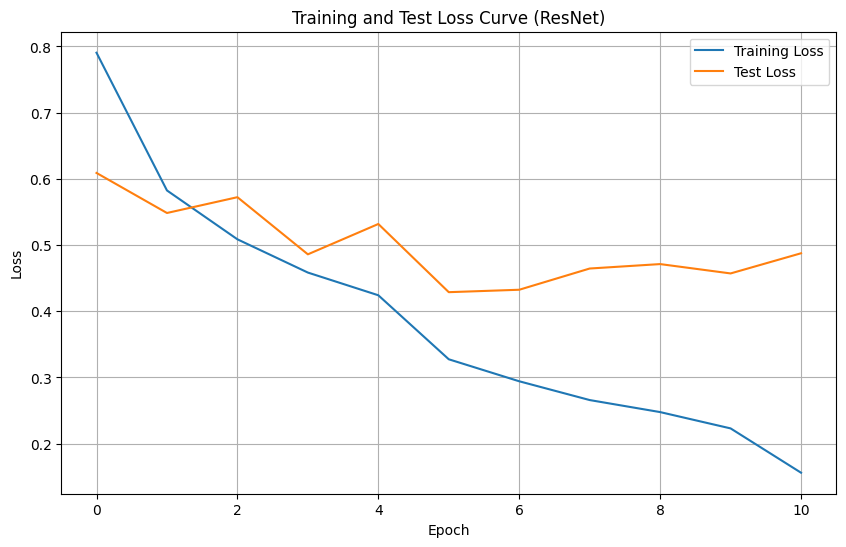

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve (ResNet)')
plt.legend()
plt.grid()
plt.show()

### Plot Confusion Matrix

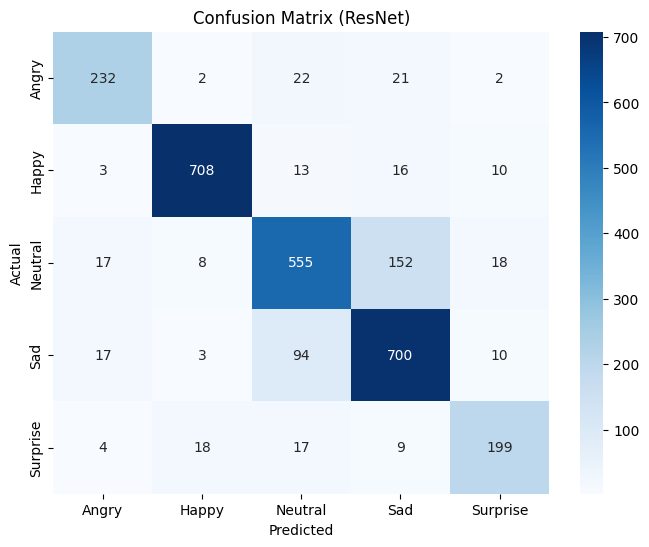

In [11]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (ResNet)')
plt.show()

---